# FrankLabToNelpy

This is based on Caleb's `PickleFrankLabData.ipynb`, but adds several additional pieces (run epochs, ripples, tuning curves, ...)

In [1]:
%load_ext watermark
%watermark -a "Etienne Ackermann," -n -t -v -p nelpy,numpy,scipy,pandas

Etienne Ackermann, Fri Dec 01 2017 22:51:05 

CPython 3.6.3
IPython 6.1.0

nelpy 0.1.1
numpy 1.12.1
scipy 0.19.1
pandas 0.21.0


C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


**Sleuthing:** 

`Con` is rat 1 (from task description); `Bon` is rat 2 (from supplementary figure 4), and `Fra` is rat 3.

# Overview

Here we load data obtained from CRCNS.org (https://crcns.org/data-sets/hc/hc-6) into python and into `nelpy` (https:github.com/nelpy/nelpy).

We will reproduce several results from https://www.nature.com/articles/nn.2344, and show how we can use HMMs to perform a similar remote replay analysis.

In [2]:
import numpy as np
import frank_lab

In [3]:
fileroot = '../../../FrankLabData/'

In [4]:
import os
anim_dirs = [(d[:3], os.path.join(fileroot,d)) for d in os.listdir(fileroot) if os.path.isdir(os.path.join(fileroot,d))]
print(anim_dirs)

[('Bon', '../../../FrankLabData/Bon'), ('Con', '../../../FrankLabData/Con_'), ('Fra', '../../../FrankLabData/Fra')]


In [5]:
import pandas as pd

verbose = 0

#animals = ['Bon', 'Con', 'Fra', 'Dud', 'Fiv', 'Eig', 'Cor', 'Ten', 'Mil']
#animals = [ 'Eig', 'Cor', 'Ten']
animals = ['Bon','Con','Fra']

# don't include Miles - his position is weird
#animals.remove('Mil')

taskinfo = {}
for (anim, adir) in anim_dirs:
    taskinfo[anim] = frank_lab.load_data(adir, datatype='task', verbose=verbose)
df = pd.DataFrame([])
for anim in animals:
    taskinfo[anim].insert(0,'Animal',anim)
    df = df.append(taskinfo[anim], ignore_index=True)
taskinfo = df

In [6]:
from ast import literal_eval 

cellinfo = {}
for (anim, adir) in anim_dirs:
    cellinfo[anim], _ = frank_lab.load_data(adir, datatype='cellinfo', verbose=verbose)

df = pd.DataFrame([])
for anim in animals:
    cellinfo[anim].insert(0,'Animal',anim)
    cellinfo[anim].index = cellinfo[anim].index.map(lambda x: str( (anim,) + literal_eval(x)))
    df = df.append(cellinfo[anim])

cellinfo = df

In [7]:
import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

import warnings

In [8]:
data = dict()

for animal in animals:
    data[animal] = dict()
    adir = next(d[1] for d in anim_dirs if d[0] == animal)
    tetinfo, _ = frank_lab.load_data(adir, datatype='tetinfo', verbose=verbose)
    spikes = frank_lab.load_data(adir, datatype='spikes', verbose=verbose)
    matpos = frank_lab.load_data(adir, datatype='pos', verbose=verbose)
    posdf = (matpos.dropna(axis=0, subset=['time','x'])
                   .groupby(['Day'], as_index=False)
                   .agg({'time' : lambda x: tuple(x),
                         'x' : lambda x: tuple(x),
                         'y' : lambda x: tuple(x),
                         'vel' : lambda x: tuple(x),
                         'dir' : lambda x: tuple(x)
                        }))    
    for var in ['time','x','y','vel','dir']:
        posdf[var] = posdf[var].apply(np.hstack)       
    
    for day in spikes['Day'].unique():
        data[animal]['Day' + str(day)] = dict()
        # Position data
        pp = posdf.query('Day==@day')
        pos = nel.AnalogSignalArray(np.vstack((pp.iloc[0].x, pp.iloc[0].y)), 
                                    timestamps=pp.iloc[0].time, fs=30)
        pos._support = pos.support.merge(gap=3/30)
        data[animal]['Day' + str(day)]['pos'] = pos
        
        speed = nel.utils.dxdt_AnalogSignalArray(pos.smooth(sigma=0.62), sigma=0.05, smooth=True)
        data[animal]['Day' + str(day)]['speed'] = speed

        support = pos.support # there should be one epoch per experimental epoch
        
        task_metadata = taskinfo.query('Animal==@animal & Day==@day')
        task_metadata = task_metadata.merge(matpos.query('Day==@day')[['Epoch','cmperpixel']],how='outer',on=['Epoch'])
        task_metadata.drop(['Animal','Day'],axis=1)
        data[animal]['Day' + str(day)]['task_metadata'] = task_metadata
        data[animal]['Day' + str(day)]['task_epochs'] = support
        
        if support.n_epochs != task_metadata.shape[0] :
            warnings.warn('Number of epochs in support does not match task_metadata rows')
            print('Animal: {}, Day: {}'.format(animal,day))
            print('number of support epochs: {}'.format(support.n_epochs))
            print('number of task epochs: {}'.format(task_metadata.shape[0]))
            
        TetrodeList = list(set(tetinfo.query("Day==@day & area=='CA1' & representative==1").Tetrode.tolist()))

        ep_list = task_metadata.Epoch.values.tolist()
        
        # We know both EEG and position data are missing for Fra day 3 ep 0:
        if (animal == 'Fra') and (day==3):
            ep_list = np.arange(1, support.n_epochs+1)
        
        eeg_data = []
        eeg_timestamps = []
        for ep in ep_list:
            eeg = frank_lab.load_data(adir, day=day+1, epoch=ep+1, tetrode=TetrodeList[0]+1, version='new', verbose=verbose)
            eeg_data.append(eeg.data)
            eeg_timestamps.append(eeg.starttime + np.array(range(len(eeg.data))) / eeg.samprate)

        # might as well build one AnalogSignalArray for the eeg data:
        eeg = nel.AnalogSignalArray(ydata=np.hstack(eeg_data), timestamps=np.hstack(eeg_timestamps), fs=1500)
        eeg = eeg[support]
        data[animal]['Day' + str(day)]['eeg'] = eeg
            
        spikedf = (spikes.query('Day==@day',inplace=False)
                      .dropna(axis=0, subset=['spiketimes'])
                      .groupby(['Tetrode','Cell'], as_index=False)
                      .agg({'spiketimes': lambda x: tuple(x),
                            'spikewidth' : lambda x: np.unique(list(x.dropna())) if list(x.dropna()) else None}))
                                          
        unit_ids = spikedf.index.tolist()
        numspikes = []
        timestamps = []
        for idx, neuron in spikedf.iterrows() :
            timestamps.append(np.hstack(neuron.spiketimes))
            numspikes.append(len(np.hstack(neuron.spiketimes)))
            
        spikedf['numspikes'] = numspikes

        cell_metadata = (cellinfo.query('Animal==@animal & Day==@day',inplace=False)
            .groupby(['Tetrode','Cell'], as_index=False)
            .agg({'area' : lambda x: np.unique(list(x.dropna())) if list(x.dropna()) else None}))
                  #'layer' : lambda x: x.unique(),
                  #'fs' : lambda x: None if x.last_valid_index() is None else x.loc[x.last_valid_index()]
        cell_metadata = spikedf[['Tetrode','Cell','spikewidth','numspikes']].merge(cell_metadata, on=['Tetrode','Cell'])
                
        data[animal]['Day' + str(day)]['cell_metadata'] = cell_metadata

        st = nel.SpikeTrainArray(timestamps, unit_ids=unit_ids,support=support, fs=10000)
        data[animal]['Day' + str(day)]['spikes'] = st

d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Animal: Fra, Day: 3
number of support epochs: 6
number of task epochs: 7


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps i

### Patch up epochs for Fra Day 3

There was a failed sleep session (the very first task epoch) so that no position data is available. Consequently, we add in a length-0 support at the start, so that the number of epochs are matched between the nelpy objects and the task table.

In [9]:
data['Fra']['Day3']['task_metadata']

,Animal,Day,Epoch,type,exposure,environment,description,sleepnum,dailyexposure,exposureday,experimentday,tracksexperienced,dailytracksexperienced,linearcoord,cmperpixel
0,Fra,3,0,failed sleep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fra,3,1,run,5.0,TrackB,TrackB,NaN,1.0,3.0,9.0,NaN,NaN,[[[[ 207.88018433 207.88018433 207.88018433 ...,0.9
2,Fra,3,2,sleep,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.9
3,Fra,3,3,run,6.0,TrackB,TrackB,NaN,2.0,3.0,9.0,NaN,NaN,[[[[ 207.60368664 207.60368664 207.60368664 ...,0.9
4,Fra,3,4,sleep,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.9
5,Fra,3,5,run,15.0,TrackA,TrackA,NaN,1.0,9.0,9.0,NaN,NaN,[[[[ 134.42396313 134.42396313 134.42396313 ...,0.9
6,Fra,3,6,sleep,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.9


In [10]:
data['Fra']['Day3']['task_epochs'] = data['Fra']['Day3']['task_epochs'] + nel.EpochArray((-1,-1))
data['Fra']['Day3']['eeg']._support = data['Fra']['Day3']['task_epochs']
data['Fra']['Day3']['pos']._support = data['Fra']['Day3']['task_epochs']
data['Fra']['Day3']['speed']._support = data['Fra']['Day3']['task_epochs']
data['Fra']['Day3']['spikes']._support = data['Fra']['Day3']['task_epochs']

In [20]:
import natsort as ns

animals = []
days = []
for animal in data:
    animal_days = []
    animals.append(animal)
    for day in data[animal]:
        animal_days.append(day)
    days.append(ns.natsorted(animal_days))
    
animalorder = ns.index_natsorted(animals)
animals = np.array(animals)[animalorder].tolist()
days = np.array(days)[animalorder].tolist()

#now zip these together:
sessions = []
for aa, animal in enumerate(animals):
    for day in days[aa]:
        sessions.append((animal, day))

# final usage:
for animal, day in sessions:
    print(animal, day)

Bon Day2
Bon Day3
Bon Day4
Bon Day5
Bon Day6
Bon Day7
Bon Day8
Bon Day9
Con Day0
Con Day1
Con Day2
Con Day3
Con Day4
Con Day5
Fra Day1
Fra Day2
Fra Day3
Fra Day4
Fra Day5
Fra Day6
Fra Day7
Fra Day8
Fra Day9
Fra Day10
Fra Day11


In [12]:
def detect_ripples(eeg):
    """Detect sharp wave ripples (SWRs) from single channel eeg (AnalogSignalArray).
    """
    
    # Maggie defines ripples by doing:
    #  (1) filter 150-250
    #  (2) hilbert envelope
    #  (3) smooth with Gaussian (4 ms SD)
    #  (4) 3.5 SD above the mean for 15 ms
    #  (5) full ripple defined as window back to mean

    assert eeg.n_signals == 1, "only single channel ripple detection currently supported!"
    
    # (1)
    ripple_eeg = nel.filtering.sosfiltfilt(eeg, fl=150, fh=250)
    # (2, 3)
    ripple_envelope = nel.utils.signal_envelope1D(ripple_eeg, sigma=0.004)
    # (4, 5)
    bounds, maxes, events = nel.utils.get_events_boundaries(
                x=ripple_envelope.ydata,
                PrimaryThreshold=ripple_envelope.mean() + 3.0*ripple_envelope.std(),   # cm/s
                SecondaryThreshold=ripple_envelope.mean(),  # cm/s
                minThresholdLength=0.015, # threshold crossing must be at least 15 ms long
                minLength=0.0, # total ripple duration must be at least XXX ms long
                ds = 1/ripple_envelope.fs
            )

    # convert bounds (in samples) to time in seconds
    timebounds = ripple_envelope.time[bounds]

    # add 1/fs to stops for open interval
    timebounds[:,1] += 1/eeg.fs

    # create EpochArray with bounds
    ripple_epochs = nel.EpochArray(timebounds)
    return ripple_epochs
    

# Add ripples from all [CA1] tetrodes

In [14]:
for animal in animals:
    adir = next(d[1] for d in anim_dirs if d[0] == animal)
    tetinfo, _ = frank_lab.load_data(adir, datatype='tetinfo', verbose=verbose)
    spikes = frank_lab.load_data(adir, datatype='spikes', verbose=verbose)
    
    for day in spikes['Day'].unique():
        print(animal, day)
        task_metadata = data[animal]['Day' + str(day)]['task_metadata']
        support = data[animal]['Day' + str(day)]['task_epochs']
            
        TetrodeList = list(set(tetinfo.query("Day==@day & area=='CA1'").Tetrode.tolist()))
        ep_list = task_metadata.Epoch.values.tolist()
        
        # We know both EEG and position data are missing for Fra day 3 ep 0:
        if (animal == 'Fra') and (day==3):
            ep_list = np.arange(1, len(ep_list))
        
        ripples_all_tetrodes = []
        for tet in TetrodeList:
            eeg_data = []
            eeg_timestamps = []
            for ep in ep_list:
                eeg = frank_lab.load_data(adir, day=day+1, epoch=ep+1, tetrode=tet+1, version='new', verbose=verbose)
                eeg_data.append(eeg.data)
                eeg_timestamps.append(eeg.starttime + np.array(range(len(eeg.data))) / eeg.samprate)

            # now build an eeg object for all epochs, for a single tetrode:
            eeg = nel.AnalogSignalArray(ydata=np.hstack(eeg_data), timestamps=np.hstack(eeg_timestamps), fs=1500)
            eeg = eeg[support]
            ripple_epochs = detect_ripples(eeg)
            ripples_all_tetrodes.append(ripple_epochs)
        data[animal]['Day' + str(day)]['ripple_epochs'] = np.sum(ripples_all_tetrodes)

Bon 2


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Bon 3


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Bon 4


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Bon 5


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Bon 6


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Bon 7


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Bon 8


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Bon 9


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Con 0


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Con 1


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Con 2


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:332: UserWarning: Data is _not_ sorted! Data will be sorted automatically.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:332: UserWarning: Data is _not_ sorted! Data will be sorted automatically.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_anal

Con 3


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Con 4


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Con 5


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Fra 1


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Fra 2


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Fra 3


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Fra 4


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Fra 5


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Fra 6


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Fra 7


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Fra 8


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Fra 9


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Fra 10


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

Fra 11


d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
d:\dropbox\code\nelpy\nelpy\utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
d:\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:

In [15]:
tetinfo = {}
for (anim, adir) in anim_dirs:
    tetinfo[anim],_ = frank_lab.load_data(adir, datatype='tetinfo')
df = pd.DataFrame([])
for anim in animals:
    tetinfo[anim].insert(0,'Animal',anim)
    df = df.append(tetinfo[anim], ignore_index=True)
tetinfo = df

Loading bontetinfo.mat
Loading contetinfo.mat
Loading fratetinfo.mat


### Optionally drop the representative eeg from the data dictionary (saves space for more lightweight work)

In [16]:
drop_eeg = False

if drop_eeg:
    for animal, day in sessions:
        try:
            data[animal][day].pop('eeg', None)
        except:
            pass

### Save nelpy data to file

In [17]:
FrankLabData = nel.ResultsContainer(data=data,
                                    sessions=sessions,
                                    cellinfo=cellinfo,
                                    taskinfo=taskinfo,
                                    tetinfo=tetinfo,
                                    description='Data from the lab of Loren Frank CRCNS archive.')
FrankLabData.save_pkl(fileroot + 'FrankLabData-BonConFra-no-eeg01.nel')

# Create task graph summary, with cell counts, exposures, and ripple counts

In [1]:
animals = ['Con', 'Bon', 'Fra'] # corresponding to Rats 1, 2, 3 of "Awake replay of experiences in the hippocampus", Karlsson (2009)

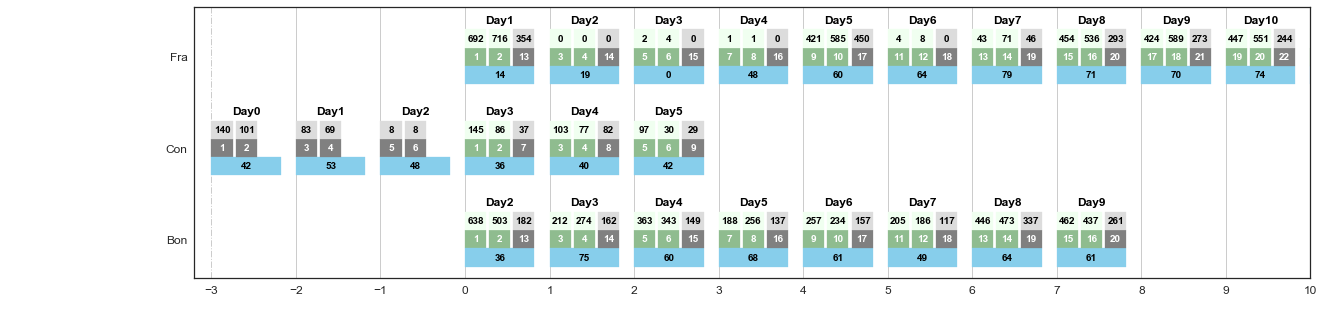

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 
            'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')

w = 0.25 # make patches a little less than 1/3rd to provide spacing
h = 0.2
dh = 0.2

fig, ax = plt.subplots(figsize=(20, 5))

rowidx = 0
rownames = []
for an in animals:
    rownames.append(an)
    tt = taskinfo.query('Animal==@an & type=="run"')
    day_first_B = tt.query('description=="TrackB" & exposure == 1.0')['Day']

    for index, row in tt.iterrows() :
        # find first TrackA exposure for each day
        day = row['Day'] - day_first_B
        ep = row['Epoch'] // 2 # runs are always 1, 3, 5 - integer division gives us 0, 1, 2
        x = day + ep / 3.5 # offset within day is by epoch
        
        if (row['description'] == 'TrackA'):
            tag = '{:d}'.format(int(row['exposure']))
            r = mpatch.Rectangle((x,rowidx + dh), w, h, color='grey')
        else :
            tag = '{:d}'.format(int(row['exposure']))
            r = mpatch.Rectangle((x,rowidx + dh), w, h, color='darkseagreen')

        ax.add_patch(r)
        cx = x + w/2.0
        cy = rowidx + dh + h/2.0

        ax.annotate(tag, (cx, cy), color='w', weight='bold', 
                    fontsize=10, ha='center', va='center')
        
        dk = 'Day' + str(np.asscalar(day_first_B.values + day.values))
        if (row['description'] == 'TrackA'):
            tag = data[an][dk]['ripple_epochs'][data[an][dk]['task_epochs'][ep*2+1]].n_epochs
            r = mpatch.Rectangle((x,rowidx + 2*dh), w, h, color='gainsboro')
        else :
            tag = data[an][dk]['ripple_epochs'][data[an][dk]['task_epochs'][ep*2+1]].n_epochs
            r = mpatch.Rectangle((x,rowidx + 2*dh), w, h, color='honeydew')

        ax.add_patch(r)
        cx = x + w/2.0
        cy = rowidx + 2*dh + h/2.0

        ax.annotate(tag, (cx, cy), color='k', weight='bold', 
                    fontsize=10, ha='center', va='center')


        if (ep == 0):
            dd = row['Day']
            ncells = len(cellinfo.query('Animal==@an & Day==@dd & Epoch==0'))
            rcells = mpatch.Rectangle((day,rowidx), 2/3.5 + w, dh, color='skyblue')
            ax.add_patch(rcells)
            cy = dh/2.0

            ax.annotate('{:d}'.format(ncells), (x + (2/3.5 + w)/2, rowidx + cy), color='k', weight='bold', 
                        fontsize=10, ha='center', va='center')

            ax.annotate(dk, (x + (2/3.5 + w)/2, rowidx + 3.5*2*cy), color='k', weight='bold', 
                        fontsize=12, ha='center', va='center')
        
    rowidx = rowidx + 1

# ax.autoscale_view(True,True,True)
ax.set_ylim(-0.13,2.85)
ax.set_xlim(-3.2,10)
ax.set_yticks(np.arange(rowidx)+h*1.5)
ax.set_xticks(np.arange(-3,11))
ax.set_yticklabels(rownames)
ax.xaxis.grid(True)
ax.get_xgridlines()[0].set_linestyle('-.')
plt.show()
